# Airbnb insights of Sevilla, Spain

In this notebook, I will be doing some analysis of the data downloaded from the Airbnb website for the spanish city of Sevilla


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Popularity of Sevilla, price variability and availability](#Popularity-of-Sevilla-and-price-variability)<br>
III. [Popularity of the different neighborhoods](#Popularity-of-the-different-neighborhoods)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)



In [406]:
# Let's get started by importing the necessary libraries and reading in the data.
import pandas as pd
import numpy as np
from itertools import cycle, islice

import matplotlib.pyplot as plt
import seaborn as sns

#% pip install wordcloud
from wordcloud import WordCloud
import string

import nltk
import os

import nltk.corpus
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer

# display setup
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
pd.set_option('max_colwidth', 200)

In [386]:
listing = pd.read_csv('listings.csv')
review = pd.read_csv('reviews.csv')
calendar = pd.read_csv('calendar.csv')
neighbourhoods = pd.read_csv('neighbourhoods.csv')

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Below I will provide some insight into the descriptive statistics of the data.

`1.` Overview of the datasets

In [389]:
print('Excerpt of the \'listings\' dataset:')
listing.head(4)

Excerpt of the 'listings' dataset:


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,32347,Explore Cultural Sights from a Family-Friendly Apartment,139939,Alejandro,Casco Antiguo,San Vicente,37.39468,-6.00183,Entire home/apt,99,2,168,2020-01-08,1.37,1,257
1,49287,BEAUTIFUL APARTMENT IN SEVILLE,224697,Walter,Casco Antiguo,Feria,37.39855,-5.99365,Entire home/apt,55,1,42,2020-02-17,0.35,1,302
2,94187,(2) ROOM + PRIVATE BATHROOM. CASA DEL BUEN VIAJE,503692,Margot,Casco Antiguo,San Bartolomé,37.39012,-5.98676,Private room,59,2,75,2019-06-05,0.66,6,245
3,108568,TERRACE ALAMEDA. WIFI GARAGE DOWNTOWN,589600,Miguel,Casco Antiguo,Feria,37.39939,-5.99237,Entire home/apt,65,3,81,2019-12-29,0.71,13,341


In [390]:
print('Excerpt of the \'reviews\' dataset:')
review.head(4)

Excerpt of the 'reviews' dataset:


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,32347,166105,2011-01-05,177444,Peter,Great location and great host!
1,32347,238321,2011-04-25,356558,Nicholas,"excellent apartment, great location"
2,32347,508902,2011-09-06,723051,Nadine,"My parents and I had a fabulous stay in Alex's apartment. Such a great first experience of stunning Seville. Just as described the apartment is only 5 minutes walk to Sierpes, which is the main s..."
3,32347,1056439,2012-03-28,873621,Cathy,"We had a fantastic stay. Alex's apartment is beautiful; clean, uncluttered, yet homely. Alex was a great host, flexible to our timings, very generous with extra treats and very friendly. Seville..."


In [391]:
print('Excerpt of the \'calendar\' dataset:')
calendar.head(4)

Excerpt of the 'calendar' dataset:


,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,879051,2021-02-01,t,$50.00,$50.00,2.0,365.0
1,32347,2021-01-31,f,$99.00,$99.00,2.0,1125.0
2,32347,2021-02-01,f,$99.00,$99.00,2.0,1125.0
3,32347,2021-02-02,f,$99.00,$99.00,2.0,1125.0


In [392]:
print('Excerpt of the \'neighbourhoods\' dataset:')
neighbourhoods.head(4)

Excerpt of the 'neighbourhoods' dataset:


,neighbourhood_group,neighbourhood
0,Casco Antiguo,Alfalfa
1,Casco Antiguo,Arenal
2,Casco Antiguo,"Encarnación, Regina"
3,Casco Antiguo,Feria


`2.` Check for columns that have missing values

In [399]:
nulls_listing = set(listing.columns[listing.isnull().mean()!=0])
print('Columns with null values in the \'listings\'dataset:', nulls_listing)

nulls_calendar = set(calendar.columns[calendar.isnull().mean()!=0])
print('Columns with null values in the \'calendar\'dataset:', nulls_calendar)

nulls_review = set(review.columns[review.isnull().mean()!=0])
print('Columns with null values in the \'reviews\'dataset:', nulls_review)

nulls_neighbourhoods = set(neighbourhoods.columns[neighbourhoods.isnull().mean()!=0])
print('Columns with null values in the \'neighbourhoods\'dataset:', nulls_neighbourhoods)

Columns with null values in the 'listings'dataset: {'last_review', 'host_name', 'reviews_per_month'}
Columns with null values in the 'calendar'dataset: {'maximum_nights', 'minimum_nights'}
Columns with null values in the 'reviews'dataset: {'comments'}
Columns with null values in the 'neighbourhoods'dataset: set()


1. Is Sevilla a popular city the whole year or is seasonal? How price and availability change?
2. How has changed the market through the years?
3. Is neighbourhood related to prices?

### <a class="anchor" id="Popularity-of-Sevilla-and-price-variability">Part II : Popularity of Sevilla, price variability and availability</a>

The aim of this section is to find out how popular Sevilla is through the years and if it has an impact on the price

`1.` What are the most popular months?

Here I will be using the review and calendar datasets. The date column needs to be split to use it

In [409]:
# Function to split the date column
def split_date(df, column):
    df[column] =  pd.to_datetime(df[column])
    df[column+'_year'] = df[column].apply(lambda x: x.year)
    df[column+'_month'] = df[column].apply(lambda x: x.month)
    df[column+'_day'] = df[column].apply(lambda x: x.day)
    df[column+'_dayofweek'] = df[column].apply(lambda x: x.strftime('%A'))
    
# date column split
split_date(review, 'date')

In [430]:
# Check the possible duplicates in reviews by the id of the review
review[review.duplicated(subset = 'id')]

,listing_id,id,date,reviewer_id,reviewer_name,comments,date_year,date_month,date_day,date_dayofweek


In [442]:
review.groupby(['date_month'])['listing_id'].count()

date_month
1     20656
2     21260
3     22175
4     24278
5     27595
6     22891
7     18772
8     19749
9     28720
10    33619
11    22854
12    20013
Name: listing_id, dtype: int64

In [445]:
# Mean value of reviews per month on the dataset
mean_reviews = review.shape[0]/12

/Users/petanth/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


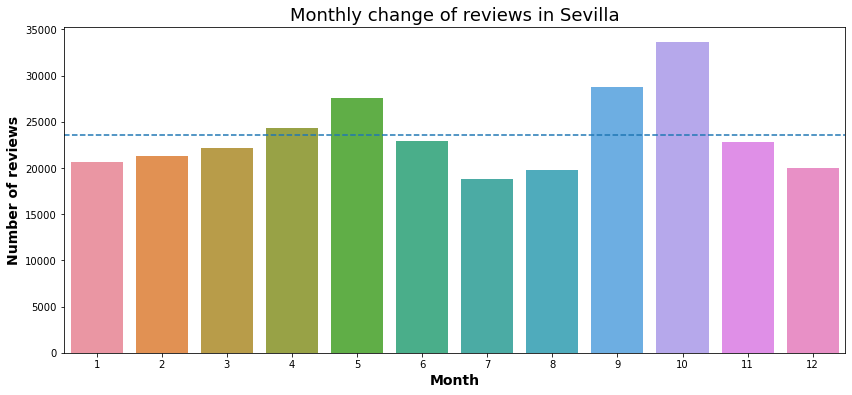

In [446]:
plt.figure(figsize = (14,6))
x = sns.countplot(review.date_month)
x.axhline(mean_reviews, ls='--')
var = x.set_title('Monthly change of reviews in Sevilla', fontsize=18)
var = x.set_xlabel('Month', fontsize=14, weight='bold')
var = x.set_ylabel('Number of reviews', fontsize=14, weight='bold')

#### As can be seen in the graphic above, the popularity has some variablity depending on the month of the year.
The following can be concluded:
- 4 months have above average visits: April, May, September and October. These coincide with moments in which people usually have holidays and also the weather in the city is more favourable to do tourism
- 2 months show a clear drop in visits: July and August. These months coincide with the moment in the year with higher temperatures in the city, with maximum average of 36 degrees and peaks of 45 degrees. If we add the fact that July and August are tipycal months when cities with coast are more popular and Sevilla has no coast, is clear why the descent in visits in this period of time on the year
- The rest of the months are below visit average but the drop is not very pronounced

`2.` How the price changes through the months?

The date column needs to be split to use it

In [448]:
# Split date data
split_date(calendar, 'date')

# Convert the price to int
def convPrice(df, column):
    df[column] = df[column].str.replace('$', '')
    df[column] = df[column].str.replace(',', '')
    df[column] = df[column].astype(float)
convPrice(calendar, 'price')
convPrice(calendar, 'adjusted_price') 

Let's first take a look at the mean prices per night for each month and plot the values:

In [564]:
calendar.groupby(['date_month'])['price', 'adjusted_price'].mean()

<ipython-input-564-324b06fc1120>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  calendar.groupby(['date_month'])['price', 'adjusted_price'].mean()


,price,adjusted_price
date_month,,
1,633.757004,632.257530
2,136.426432,136.075559
3,163.976261,163.517113
4,212.325560,211.427187
5,193.820761,192.828836
6,242.660036,241.722214
7,271.131347,270.393410
8,284.547445,283.767157
9,405.532134,404.591072


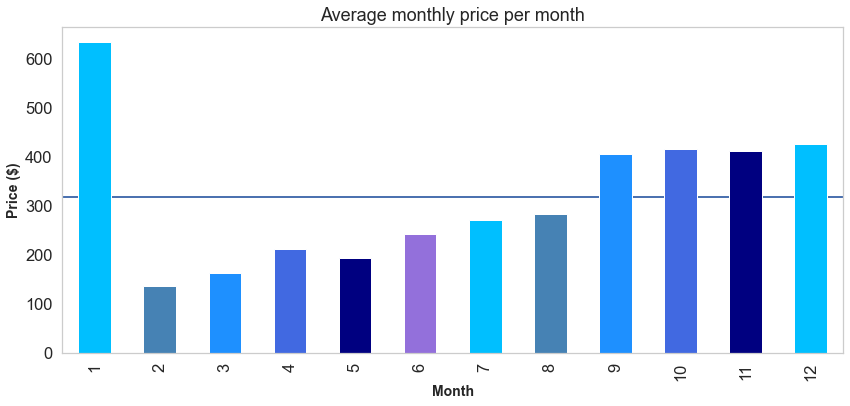

In [579]:
my_colors = list(islice(cycle(['deepskyblue', 'steelblue', 'dodgerblue', 'royalblue', 'navy', 'mediumpurple']), None, len((neighbourhoods.neighbourhood_group.unique()))))

plt.figure(figsize = (14,6))
calendar.groupby(['date_month'])['price'].mean().plot(kind = "bar", color = my_colors, zorder=2)
plt.title("Average monthly price per month", fontsize=18)
plt.xlabel('Month', fontsize=14, fontweight='bold')
plt.ylabel('Price ($)', fontsize=14, fontweight='bold')
plt.axhline(y=calendar.price.mean(), linewidth=2, color='b',zorder=1)
plt.grid(False)
plt.show()

It does not make much sense that the average price per night ranges from around 200 until more than 600.
Looking at properties of the dataset we obtain the following:


In [454]:
calendar.groupby(['date_month'])['price', 'adjusted_price'].describe()

<ipython-input-454-d626ab18fe58>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  calendar.groupby(['date_month'])['price', 'adjusted_price'].describe()


price                                                   \
               count        mean          std  min   25%   50%    75%   
date_month                                                              
1           164649.0  633.757004  2010.703940  8.0  50.0  80.0  160.0   
2           148652.0  136.426432   638.345956  8.0  45.0  65.0   95.0   
3           164579.0  163.976261   679.935193  9.0  50.0  73.0  120.0   
4           159270.0  212.325560   712.280325  9.0  56.0  90.0  165.0   
5           164579.0  193.820761   790.163314  9.0  55.0  80.0  135.0   
6           159270.0  242.660036   948.197679  9.0  51.0  80.0  131.0   
7           164579.0  271.131347  1084.345969  9.0  50.0  75.0  123.0   
8           164579.0  284.547445  1144.590327  9.0  50.0  75.0  120.0   
9           159270.0  405.532134  1538.712689  9.0  51.0  80.0  146.0   
10          164579.0  416.001483  1558.505194  9.0  52.0  80.0  150.0   
11          159270.0  411.984102  1563.075682  9.0  50.0  79.0  135.0   
12          164579.0  426.656943  1590.291990  9.0  50.0  80.0  150.0   

                    adjusted_price                                            \
                max          count        mean          std  min   25%   50%   
date_month                                                                     
1           10499.0       164649.0  632.257530  2007.770396  8.0  50.0  80.0   
2           11498.0       148652.0  136.075559   637.704086  8.0  45.0  65.0   
3           11498.0       164579.0  163.517113   679.617984  9.0  50.0  73.0   
4           11498.0       159270.0  211.427187   710.536945  9.0  55.0  90.0   
5           11498.0       164579.0  192.828836   788.649816  9.0  55.0  80.0   
6           11498.0       159270.0  241.722214   946.945498  9.0  51.0  80.0   
7           10999.0       164579.0  270.393410  1083.478495  9.0  50.0  75.0   
8           10999.0       164579.0  283.767157  1143.559015  9.0  50.0  75.0   
9           10999.0       159270.0  404.591072  1537.028327  9.0  50.0  80.0   
10          10999.0       164579.0  415.310884  1556.823479  9.0  51.0  80.0   
11          10999.0       159270.0  410.996836  1561.366753  9.0  50.0  79.0   
12          10999.0       164579.0  425.853833  1588.612238  9.0  50.0  80.0   

                            
              75%      max  
date_month                  
1           160.0  10000.0  
2            94.0  11498.0  
3           120.0  11498.0  
4           164.0  11498.0  
5           135.0  11498.0  
6           130.0  11498.0  
7           122.0  10999.0  
8           120.0  10999.0  
9           145.0  10999.0  
10          150.0  10999.0  
11          135.0  10999.0  
12          150.0  10999.0

It seems there are some outliers on the price as values with anormaly high prices per night. The maximum value of the price can reach 11498 on the dataset and it is not representative of the reality. Very likely these outliers are making our average values per month very high. 

A histogram, boxplot and scatterplot of the price data will be represented to understand better the distribution of prices on the dataset

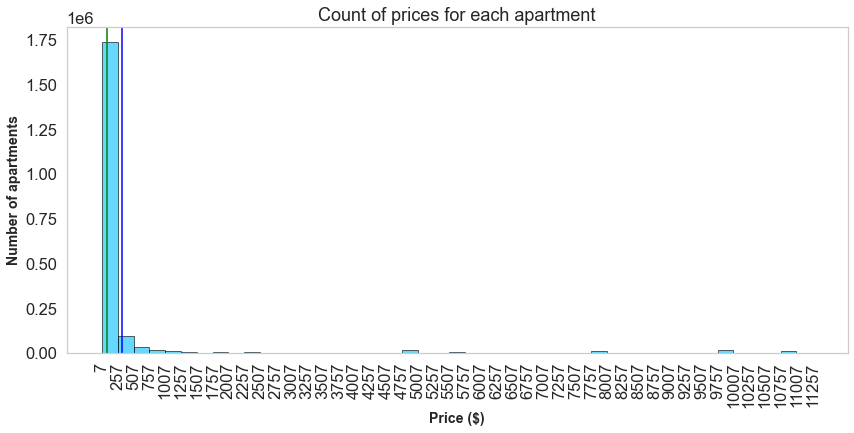

In [503]:
n_bins = np.arange(calendar.price.min()-1,calendar.price.max(),250)

plt.figure(figsize = (14,6))
plt.hist(calendar.price, bins = n_bins, alpha=0.6, histtype='bar', ec='black', color = "deepskyblue");
plt.title('Count of prices for each apartment', fontsize=18)
plt.xlabel('Price ($)', fontsize=14, fontweight='bold')
plt.ylabel('Number of apartments', fontsize=14, fontweight='bold')
plt.axvline(x = calendar.price.mean(),color = 'blue')
plt.axvline(x = calendar.price.median(),color = 'green')
plt.xticks(n_bins, rotation=90)
plt.grid(False)
plt.show()

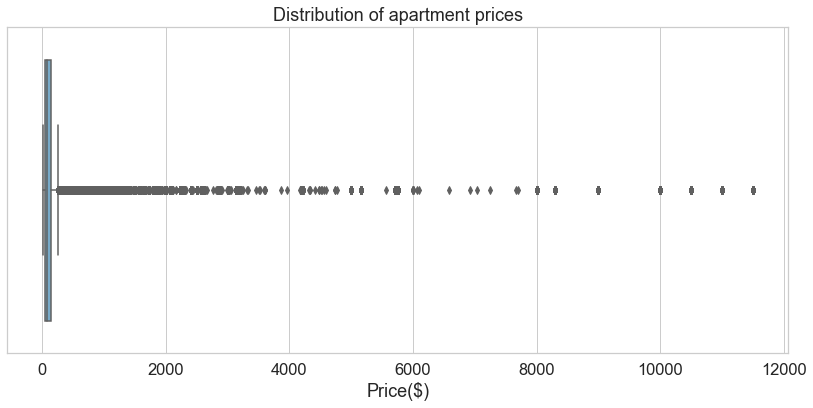

In [501]:
ax = sns.set(rc={'figure.figsize':(14,6)}, font_scale=1.5, style='whitegrid')
ax = sns.boxplot(x="price", data=calendar, palette="Blues")
ax.set_title('Distribution of apartment prices');
ax.set_xlabel('Price($)');

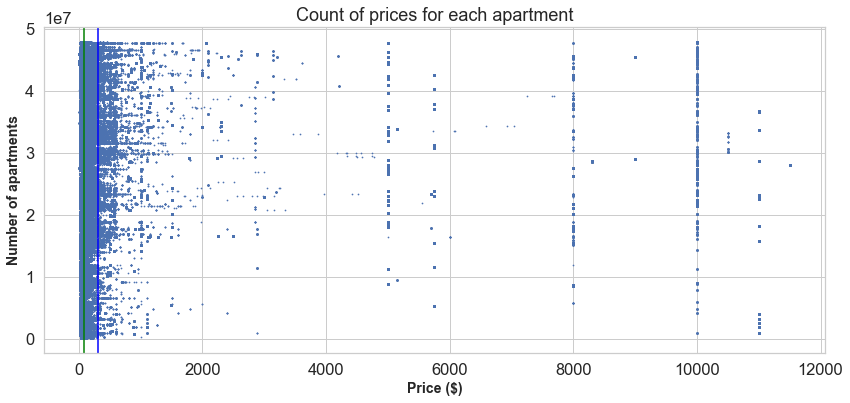

In [497]:
plt.figure(figsize = (14,6))
plt.scatter(calendar['price'], calendar['listing_id'], s = 0.5)
plt.title('Count of prices for each apartment', fontsize=18)
plt.xlabel('Price ($)', fontsize=14, fontweight='bold')
plt.ylabel('Number of apartments', fontsize=14, fontweight='bold')
plt.axvline(x = calendar.price.mean(),color = 'blue');
plt.axvline(x = calendar.price.median(),color = 'green');

It can be seen that there are values that can be considered as outliers for the price since the majority of the prices are between 0 and 250. I will check the meadian values for the price since it is a descriptive statistic that is more robust than the mean against outliers

In [504]:
calendar.groupby(['date_month'])['price', 'adjusted_price'].median()

<ipython-input-504-5d5f45e1df11>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  calendar.groupby(['date_month'])['price', 'adjusted_price'].median()


,price,adjusted_price
date_month,,
1,80.0,80.0
2,65.0,65.0
3,73.0,73.0
4,90.0,90.0
5,80.0,80.0
6,80.0,80.0
7,75.0,75.0
8,75.0,75.0
9,80.0,80.0


The values I obtain are much more reasonable than the values obtained with the mean.

Another method to detect outliers is the IQR (Interquantile Range) that I will calculate here:

In [509]:
# Use of IQR (Interquantile Range) to detect outliers in price
Q1_price = calendar.price.quantile(0.25)
Q3_price = calendar.price.quantile(0.75)
IQR_price = Q3_price - Q1_price
print('IQR for price values:', IQR_price)

IQR for price values: 85.0


This also give us a much more reasonable average price. The values out of the IQR will be deleted from the dataset:

In [581]:
calendar_new = calendar[['price', 'adjusted_price', 'date_month']]
calendar_new.dtypes

Q1 = calendar_new.quantile(0.25)
Q3 = calendar_new.quantile(0.75)
IQR = Q3 - Q1

df_out = calendar_new[~((calendar_new < (Q1 - 1.5 * IQR)) |(calendar_new > (Q3 + 1.5 * IQR))).any(axis=1)]

print('Rows on the original dataset:', calendar.shape[0])
print('Rows on the new dataset after deleting the outliers:', df_out.shape[0])
print('Deleted rows:', calendar.shape[0]-df_out.shape[0])

Rows on the original dataset: 1937855
Rows on the new dataset after deleting the outliers: 1738179
Deleted rows: 199676


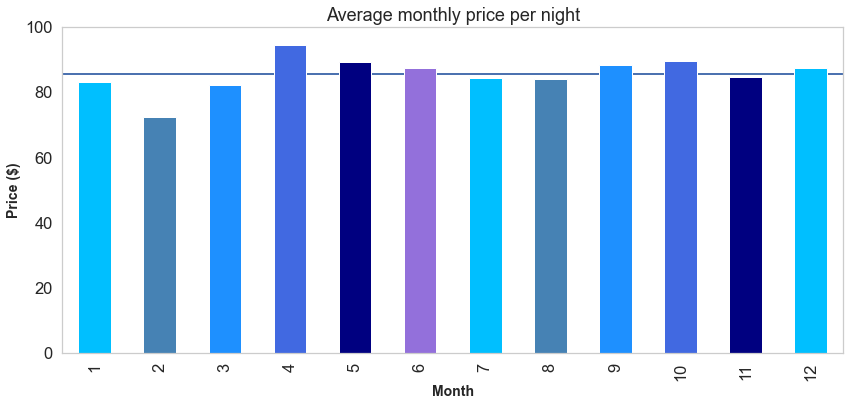

In [587]:
my_colors = list(islice(cycle(['deepskyblue', 'steelblue', 'dodgerblue', 'royalblue', 'navy', 'mediumpurple']), None, len((neighbourhoods.neighbourhood_group.unique()))))

plt.figure(figsize = (14,6))
df_out.groupby(['date_month'])['price'].mean().plot(kind = "bar", color = my_colors, zorder=2)
plt.title("Average monthly price per night", fontsize=18)
plt.xlabel('Month', fontsize=14, fontweight='bold')
plt.ylabel('Price ($)', fontsize=14, fontweight='bold')
plt.axhline(y=df_out.price.mean(), linewidth=2, color='b',zorder=1)
plt.grid(False)
plt.ylim(0, 100)
plt.show()

#### As can be seen in the graphic above, the average monthly price per night makes now much more sense.

Also we can see that the most popular month (April, May, September and October) are also those that have higher average price per night

`3.` How the availability changes depending on the month?

In [599]:
# Dummies will be generated to separate available data in 0 or 1 values
calendar_availability = pd.get_dummies(calendar, columns = ['available'])
calendar_availability.groupby(['date_month'])['available_t'].describe()
calendar_availability

,listing_id,date,price,adjusted_price,minimum_nights,maximum_nights,date_year,date_month,date_day,date_dayofweek,available_f,available_t
0,879051,2021-02-01,50.0,50.0,2.0,365.0,2021,2,1,Monday,0,1
1,32347,2021-01-31,99.0,99.0,2.0,1125.0,2021,1,31,Sunday,1,0
2,32347,2021-02-01,99.0,99.0,2.0,1125.0,2021,2,1,Monday,1,0
3,32347,2021-02-02,99.0,99.0,2.0,1125.0,2021,2,2,Tuesday,1,0
4,32347,2021-02-03,99.0,99.0,2.0,1125.0,2021,2,3,Wednesday,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1937850,47947887,2022-01-26,49.0,49.0,1.0,1125.0,2022,1,26,Wednesday,0,1
1937851,47947887,2022-01-27,49.0,49.0,1.0,1125.0,2022,1,27,Thursday,0,1
1937852,47947887,2022-01-28,49.0,49.0,1.0,1125.0,2022,1,28,Friday,0,1
1937853,47947887,2022-01-29,49.0,49.0,1.0,1125.0,2022,1,29,Saturday,0,1


In [594]:
calendar_availability.groupby(['date_month'])['available_t'].mean()

date_month
1     0.429495
2     0.666241
3     0.688065
4     0.641521
5     0.608413
6     0.619935
7     0.629333
8     0.527321
9     0.506159
10    0.501085
11    0.479080
12    0.474410
Name: available_t, dtype: float64

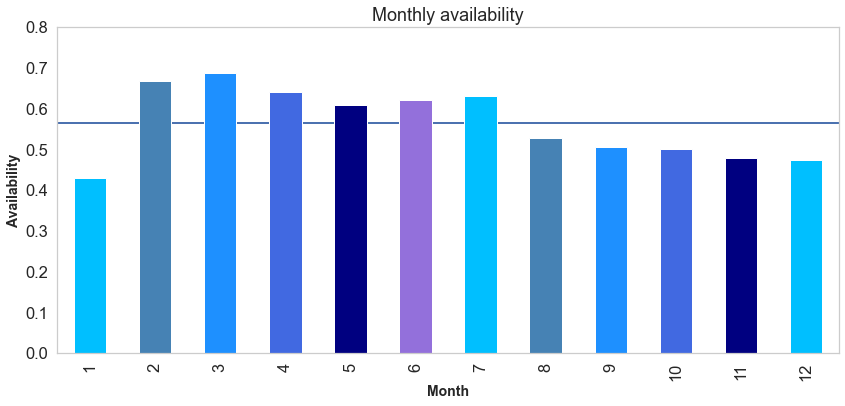

In [598]:
my_colors = list(islice(cycle(['deepskyblue', 'steelblue', 'dodgerblue', 'royalblue', 'navy', 'mediumpurple']), None, len((neighbourhoods.neighbourhood_group.unique()))))


plt.figure(figsize = (14,6))
calendar_availability.groupby(['date_month'])['available_t'].mean().plot(kind = "bar", color = my_colors, zorder=2)
plt.title("Monthly availability", fontsize=18)
plt.xlabel('Month', fontsize=14, fontweight='bold')
plt.ylabel('Availability', fontsize=14, fontweight='bold')
plt.axhline(y=calendar_availability.available_t.mean(), linewidth=2, color='b',zorder=1)
plt.grid(False)
plt.ylim(0, 0.8)
plt.show()

Here I will delete the rows with outliers in price and check if it has an impact in the availability:

In [624]:
calendar_av_new = calendar_availability[['price', 'adjusted_price', 'date_month', 'available_f', 'available_t']]
#calendar_av_new.dtypes

Q1 = calendar_av_new.quantile(0.25)
Q3 = calendar_av_new.quantile(0.75)
IQR = Q3 - Q1

df_av_out = calendar_av_new[~((calendar_av_new < (Q1 - 1.5 * IQR)) |(calendar_av_new > (Q3 + 1.5 * IQR))).any(axis=1)]

print('Rows on the original dataset:', calendar_availability.shape[0])
print('Rows on the new dataset after deleting the outliers:', df_av_out.shape[0])
print('Deleted rows:', calendar_availability.shape[0]-df_av_out.shape[0])

Rows on the original dataset: 1937855
Rows on the new dataset after deleting the outliers: 1738179
Deleted rows: 199676


In [625]:
df_1 = calendar_availability.groupby(['date_month'])['available_t'].mean()
df_2 = df_av_out.groupby(['date_month'])['available_t'].mean()

compare_df = {'Including outliers in price': df_1,
              'Without outliers in price': df_2}

df_new = pd.DataFrame(compare_df, columns=['Including outliers in price', 'Without outliers in price'])

<Figure size 1008x432 with 0 Axes>

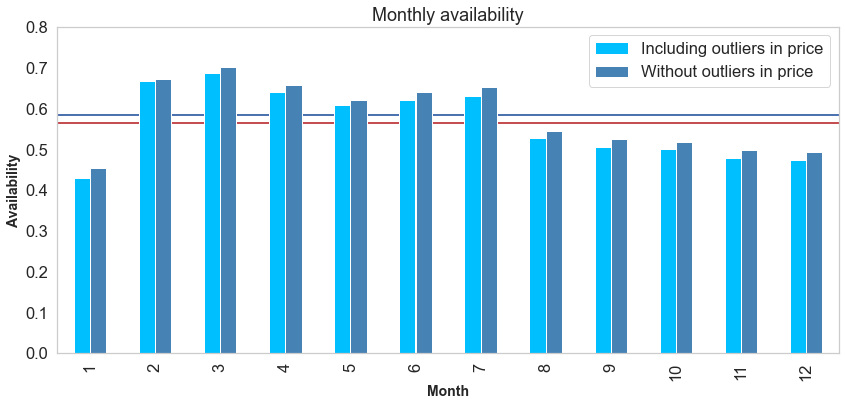

In [631]:
my_colors = list(islice(cycle(['deepskyblue', 'steelblue', 'dodgerblue', 'royalblue', 'navy', 'mediumpurple']), None, len((neighbourhoods.neighbourhood_group.unique()))))


plt.figure(figsize = (14,6))
df_new.plot(kind = "bar", color = my_colors, zorder=2)
plt.title("Monthly availability", fontsize=18)
plt.xlabel('Month', fontsize=14, fontweight='bold')
plt.ylabel('Availability', fontsize=14, fontweight='bold')
plt.axhline(y=calendar_availability.available_t.mean(), linewidth=2, color='r',zorder=1)
plt.axhline(y=df_av_out.available_t.mean(), linewidth=2, color='b',zorder=1)
plt.grid(False)
plt.ylim(0, 0.8)
plt.show()

#### As can be seen in the graphic above, removing the outliers barely have an impact in the availability. Also as general rule, on the first part of the year the availability seems to be higher

### <a class="anchor" id="Popularity-of-the-different-neighborhoods">Part III : Popularity of the different neighborhoods</a>

The aim of this section is to study the peculiarities of the different neighborhoods in Sevilla

`1.` What are the neighborhoods with the highest offer of apartments?

Number of neighbourhoods on the dataset 11


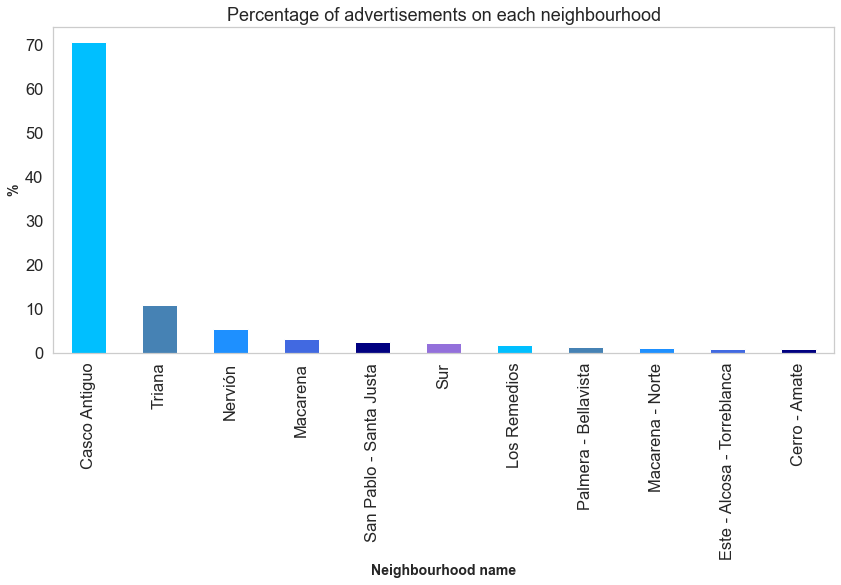

In [634]:
print('Number of neighbourhoods on the dataset', len(neighbourhoods.neighbourhood_group.unique()))

my_colors = list(islice(cycle(['deepskyblue', 'steelblue', 'dodgerblue', 'royalblue', 'navy', 'mediumpurple']), None, len((neighbourhoods.neighbourhood_group.unique()))))

status_vals = listing.neighbourhood_group.value_counts()
plt.figure(figsize = (14,6))
((status_vals/listing.shape[0])*100).plot(kind="bar", color=my_colors, stacked=True)
plt.title("Percentage of advertisements on each neighbourhood", fontsize=18)
plt.xlabel('Neighbourhood name', fontsize=14, fontweight='bold')
plt.ylabel('%', fontsize=14, fontweight='bold')
plt.grid(False)
plt.show()

From the above graphic can be observed that the neighbourhood with the most extensive offer is clearly "Casco Antiguo" with an impressive 70% of all the apartments available followed by "Triana" and "Nervion" that are between 5% and 10% of all the apartments available. The rest of the neighbourhoods barely have a representation compared to the aforementioned neighbourhoods

`2.` How is the location of the neighborhoods?

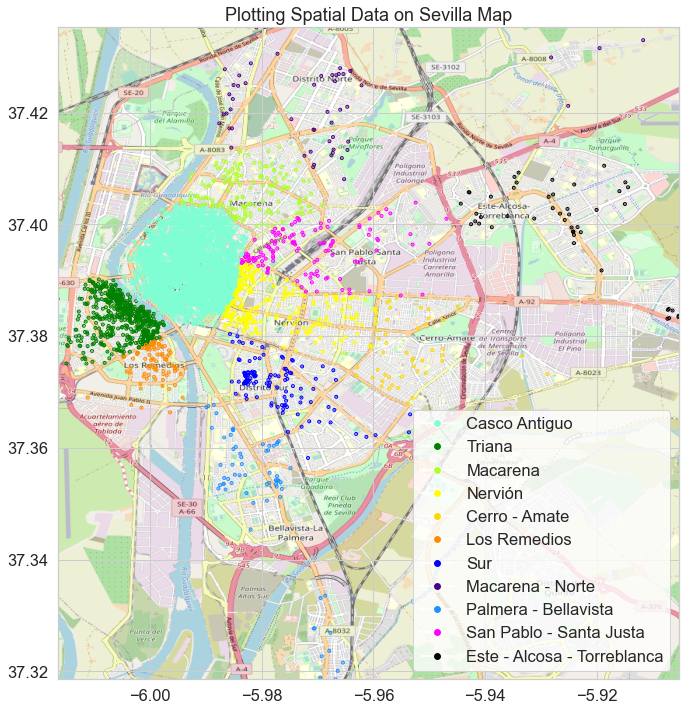

In [773]:
# Library needed for the legend
from matplotlib.lines import Line2D

BBox = ((listing.longitude.min(), listing.longitude.max(), listing.latitude.min(), listing.latitude.max()))

sev_m = plt.imread('Sevilla_map.png')

colors = {'Casco Antiguo':'aquamarine', 'Triana':'green', 'Macarena':'greenyellow', 'Nervión':'yellow',
          'Cerro - Amate':'gold', 'Los Remedios':'darkorange', 'Sur':'blue', 'Macarena - Norte':'indigo',
          'Palmera - Bellavista':'dodgerblue', 'San Pablo - Santa Justa':'fuchsia', 'Este - Alcosa - Torreblanca':'black'}

fig, ax = plt.subplots(figsize = (12,12))
ax.scatter(listing.longitude, listing.latitude, c=listing['neighbourhood_group'].map(colors), 
           alpha= 1, s=4, marker='.', linewidths=3)
ax.set_title('Plotting Spatial Data on Sevilla Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])



colors = {'aquamarine', 'green', 'greenyellow', 'yellow','gold', '', 'blue', '','', 'darkslategray', 'black'}
neigh = listing.neighbourhood_group.unique()
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Casco Antiguo',markerfacecolor='aquamarine', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='Triana',markerfacecolor='green', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='Macarena',markerfacecolor='greenyellow', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='Nervión',markerfacecolor='yellow', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='Cerro - Amate',markerfacecolor='gold', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='Los Remedios',markerfacecolor='darkorange', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='Sur',markerfacecolor='blue', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='Macarena - Norte',markerfacecolor='indigo', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='Palmera - Bellavista',markerfacecolor='dodgerblue', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='San Pablo - Santa Justa',markerfacecolor='fuchsia', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='Este - Alcosa - Torreblanca',markerfacecolor='black', markersize=8)]

ax.legend(handles=legend_elements, loc='best')

ax.imshow(sev_m, zorder=0, extent = BBox, aspect= 'equal')

`3.` How does the price between neighborhoods change?

In [776]:
listing.groupby(['neighbourhood_group'])['price'].describe().sort_values(['count'], ascending=False)

,count,mean,std,min,25%,50%,75%,max
neighbourhood_group,,,,,,,,
Casco Antiguo,3741.0,143.248329,655.073371,0.0,48.00,65.0,94.00,9999.0
Triana,577.0,122.642981,587.917795,11.0,46.00,62.0,87.00,9999.0
Nervión,282.0,124.127660,602.645211,10.0,43.00,60.0,90.00,9999.0
Macarena,164.0,54.530488,59.571314,14.0,26.75,39.5,60.00,500.0
San Pablo - Santa Justa,128.0,64.914062,65.893140,11.0,30.00,48.0,72.50,428.0
Sur,115.0,103.678261,187.204483,14.0,35.00,49.0,78.00,1100.0
Los Remedios,94.0,70.287234,57.223505,9.0,40.00,55.0,70.75,375.0
Palmera - Bellavista,66.0,62.287879,66.857544,12.0,25.00,40.5,74.00,415.0
Macarena - Norte,52.0,52.903846,51.992933,12.0,23.00,37.5,70.50,350.0


It can be seen some extrem values on the dataset. These outliers will be removed applying IQR method:

In [784]:
def apply_IQR(data, columns):
    '''
    INPUT:
    data - the dataframe where the IQR will be calculated and apply 
    columns - the columns that the resulting dataframe will have
    OUTPUT:
    df_out - the dataframe with values included only in the IQR
    
    Applies IQR to the dataframe specified by data and will output a new dataframe with only the data
    that fulfills the IQR
    '''
    data_new = data[columns]

    Q1 = data_new.quantile(0.25)
    Q3 = data_new.quantile(0.75)
    IQR = Q3 - Q1

    df_out = data_new[~((data_new < (Q1 - 1.5 * IQR)) |(data_new > (Q3 + 1.5 * IQR))).any(axis=1)]

    print('Rows on the original dataset:', data.shape[0])
    print('Rows on the new dataset after deleting the outliers:', df_out.shape[0])
    print('Deleted rows:', data.shape[0]-df_out.shape[0])
    
    return df_out

new_columns = ['price', 'neighbourhood_group']
listing_new = apply_IQR(listing, new_columns)

Rows on the original dataset: 5310
Rows on the new dataset after deleting the outliers: 4866
Deleted rows: 444


In [785]:
listing_new.groupby(['neighbourhood_group'])['price'].describe().sort_values(['count'], ascending=False)

,count,mean,std,min,25%,50%,75%,max
neighbourhood_group,,,,,,,,
Casco Antiguo,3414.0,67.382542,29.518990,0.0,46.00,62.0,83.00,155.0
Triana,525.0,63.900952,27.648587,11.0,45.00,60.0,80.00,155.0
Nervión,256.0,62.351562,31.004640,10.0,40.00,57.0,82.25,151.0
Macarena,159.0,46.377358,27.044660,14.0,26.00,39.0,60.00,150.0
San Pablo - Santa Justa,120.0,50.766667,30.374894,11.0,29.75,44.0,63.25,150.0
Sur,104.0,51.990385,28.431999,14.0,33.25,45.0,61.25,146.0
Los Remedios,88.0,58.886364,32.420524,9.0,39.75,53.0,66.75,150.0
Palmera - Bellavista,63.0,49.936508,32.325398,12.0,25.00,40.0,67.50,151.0
Macarena - Norte,51.0,47.078431,30.941780,12.0,23.00,36.0,70.00,130.0


Now the price values have a more reasonable range

<Figure size 1008x432 with 0 Axes>

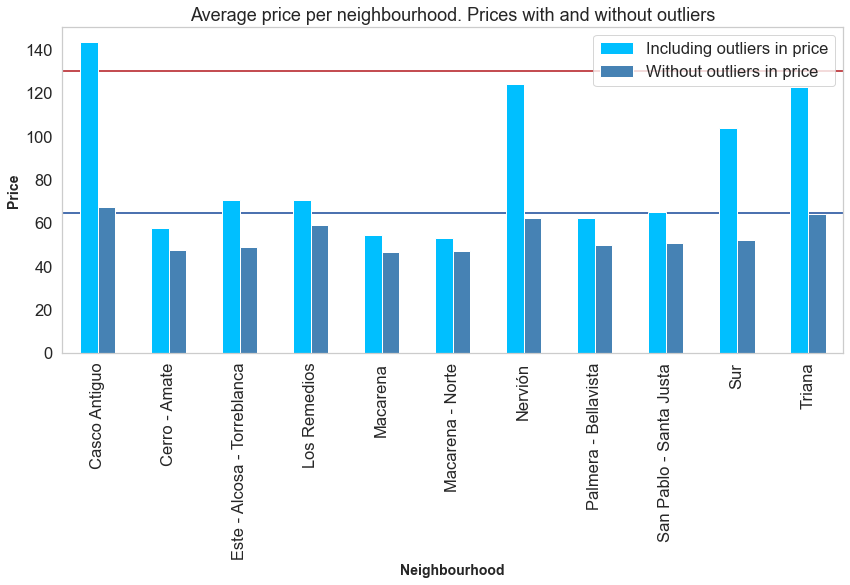

In [792]:
df_1 = listing.groupby(['neighbourhood_group'])['price'].mean()
df_2 = listing_new.groupby(['neighbourhood_group'])['price'].mean()

compare_df = {'Including outliers in price': df_1,
              'Without outliers in price': df_2}

df_new = pd.DataFrame(compare_df, columns=['Including outliers in price', 'Without outliers in price'])

my_colors = list(islice(cycle(['deepskyblue', 'steelblue', 'dodgerblue', 'royalblue', 'navy', 'mediumpurple']), None, len((neighbourhoods.neighbourhood_group.unique()))))


plt.figure(figsize = (14,6))
df_new.plot(kind = "bar", color = my_colors, zorder=2)
plt.title("Average price per neighbourhood. Prices with and without outliers", fontsize=18)
plt.xlabel('Neighbourhood', fontsize=14, fontweight='bold')
plt.ylabel('Price', fontsize=14, fontweight='bold')
plt.axhline(y=listing.price.mean(), linewidth=2, color='r',zorder=1)
plt.axhline(y=listing_new.price.mean(), linewidth=2, color='b',zorder=1)
plt.grid(False)
#plt.ylim(0, 0.8)
plt.show()

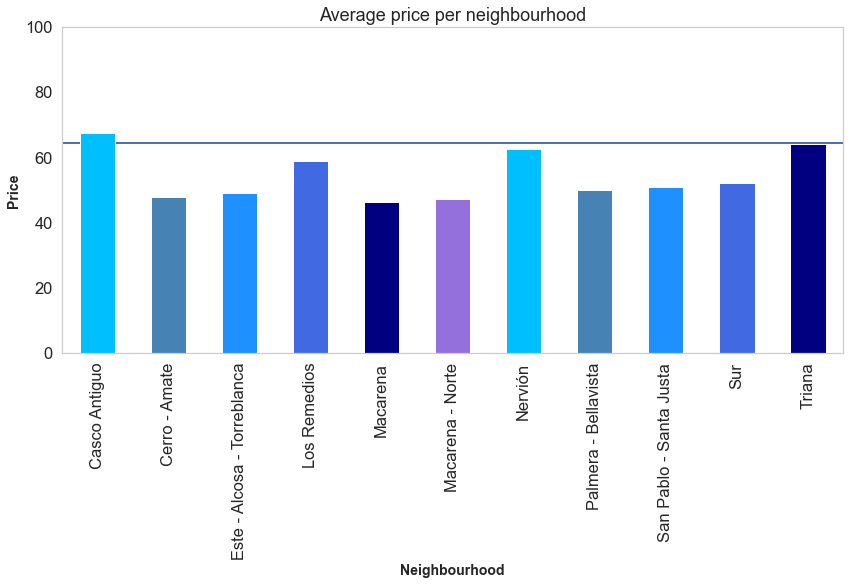

In [787]:
my_colors = list(islice(cycle(['deepskyblue', 'steelblue', 'dodgerblue', 'royalblue', 'navy', 'mediumpurple']), None, len((neighbourhoods.neighbourhood_group.unique()))))

plt.figure(figsize = (14,6))
listing_new.groupby(['neighbourhood_group'])['price'].mean().plot(kind = "bar", color = my_colors, zorder=2)
plt.title("Average price per neighbourhood", fontsize=18)
plt.xlabel('Neighbourhood', fontsize=14, fontweight='bold')
plt.ylabel('Price', fontsize=14, fontweight='bold')
plt.axhline(y=df_out.price.mean(), linewidth=2, color='b',zorder=1)
plt.grid(False)
plt.ylim(0, 100)
plt.show()

The overall average price and the average price of "Casco Antiguo" neighbourhood are very closed as expected since the amount of apartments in this zone represents around the 70% of all the offer available in the city

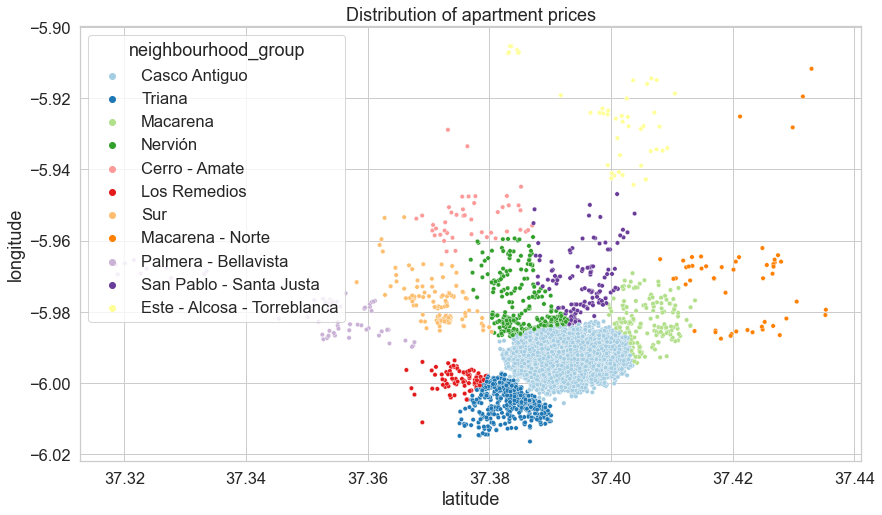

In [670]:
plt.figure(figsize = (14,8))
with sns.color_palette("Paired", 20):
    ax = sns.scatterplot(x=listing['latitude'], y=listing['longitude'], hue=listing["neighbourhood_group"], s=20, zorder=1)
ax.set_title('Distribution of apartment prices');
#plt.grid(False)

In [705]:
listing.neighbourhood_group.unique()

array(['Casco Antiguo', 'Triana', 'Macarena', 'Nervión', 'Cerro - Amate',
       'Los Remedios', 'Sur', 'Macarena - Norte', 'Palmera - Bellavista',
       'San Pablo - Santa Justa', 'Este - Alcosa - Torreblanca'],
      dtype=object)

<ipython-input-591-7721246c3cc6>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  calendar.groupby(['date_month'])['price', 'adjusted_price'].mean()
<ipython-input-591-7721246c3cc6>:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  calendar.groupby(['date_month'])['price', 'adjusted_price'].mean().plot(kind="bar", color=my_colors, stacked=False)


<Figure size 1008x432 with 0 Axes>

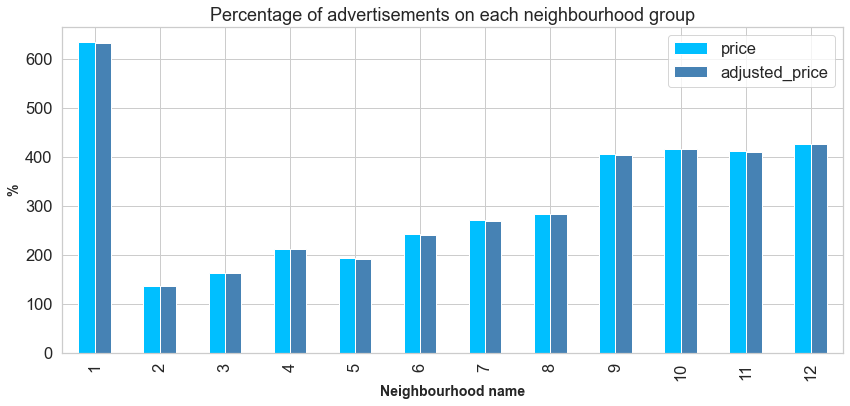

In [591]:
calendar.groupby(['date_month'])['price', 'adjusted_price'].mean()

x = calendar.groupby(['date_month'])['price']

mean_price = calendar.price.mean()

my_colors = list(islice(cycle(['deepskyblue', 'steelblue', 'dodgerblue', 'royalblue', 'navy', 'mediumpurple']), None, len((neighbourhoods.neighbourhood_group.unique()))))

plt.figure(figsize = (14,6))
calendar.groupby(['date_month'])['price', 'adjusted_price'].mean().plot(kind="bar", color=my_colors, stacked=False)
plt.title("Percentage of advertisements on each neighbourhood group", fontsize=18)
plt.xlabel('Neighbourhood name', fontsize=14, fontweight='bold')
plt.ylabel('%', fontsize=14, fontweight='bold')
plt.show()

In [426]:
# Check who visited Sevilla many times
review[review.duplicated(subset = 'reviewer_id')]
review[review.reviewer_id == 140267600]
review.groupby('reviewer_id').count().sort_values(by='id', ascending=False)
review[review.reviewer_id == 140267600].sort_values(by='date_year', ascending=False)

,listing_id,id,date,reviewer_name,comments,date_year,date_month,date_day,date_dayofweek
reviewer_id,,,,,,,,,
140267600,19,19,19,19,19,19,19,19,19
37694721,18,18,18,18,18,18,18,18,18
19185960,17,17,17,17,17,17,17,17,17
38947915,15,15,15,15,15,15,15,15,15
21070808,14,14,14,14,14,14,14,14,14
...,...,...,...,...,...,...,...,...,...
31612062,1,1,1,1,1,1,1,1,1
31612172,1,1,1,1,1,1,1,1,1
31612238,1,1,1,1,1,1,1,1,1


In [141]:
listing.neighbourhood_group

0       Casco Antiguo
1       Casco Antiguo
2       Casco Antiguo
3       Casco Antiguo
4       Casco Antiguo
            ...      
5305    Casco Antiguo
5306    Casco Antiguo
5307    Casco Antiguo
5308    Casco Antiguo
5309         Macarena
Name: neighbourhood_group, Length: 5310, dtype: object

In [434]:
review.id.describe()

count    2.825820e+05
mean     3.383802e+08
std      1.914392e+08
min      1.661050e+05
25%      1.738771e+08
50%      3.358511e+08
75%      5.068303e+08
max      7.283441e+08
Name: id, dtype: float64

In [435]:
review.listing_id.describe()

count    2.825820e+05
mean     1.464721e+07
std      1.081955e+07
min      3.234700e+04
25%      4.879329e+06
50%      1.428917e+07
75%      2.230323e+07
max      4.772619e+07
Name: listing_id, dtype: float64

In [279]:
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,879051,2021-02-01,t,$50.00,$50.00,2.0,365.0
1,32347,2021-01-31,f,$99.00,$99.00,2.0,1125.0
2,32347,2021-02-01,f,$99.00,$99.00,2.0,1125.0
3,32347,2021-02-02,f,$99.00,$99.00,2.0,1125.0
4,32347,2021-02-03,f,$99.00,$99.00,2.0,1125.0


In [505]:
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,date_year,date_month,date_day,date_dayofweek
0,879051,2021-02-01,t,50.0,50.0,2.0,365.0,2021,2,1,Monday
1,32347,2021-01-31,f,99.0,99.0,2.0,1125.0,2021,1,31,Sunday
2,32347,2021-02-01,f,99.0,99.0,2.0,1125.0,2021,2,1,Monday
3,32347,2021-02-02,f,99.0,99.0,2.0,1125.0,2021,2,2,Tuesday
4,32347,2021-02-03,f,99.0,99.0,2.0,1125.0,2021,2,3,Wednesday


In [272]:
# Check values ordered by year
calendar.sort_values(by='date_year', ascending=False)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,date_year,date_month,date_day,date_dayofweek
1937854,47947887,2022-01-30,t,49.0,49.0,1.0,1125.0,2022,1,30,Sunday
430343,16903143,2022-01-09,f,62.0,62.0,1.0,1125.0,2022,1,9,Sunday
430349,16903143,2022-01-15,f,70.0,70.0,1.0,1125.0,2022,1,15,Saturday
430348,16903143,2022-01-14,f,70.0,70.0,1.0,1125.0,2022,1,14,Friday
430347,16903143,2022-01-13,f,62.0,62.0,1.0,1125.0,2022,1,13,Thursday
...,...,...,...,...,...,...,...,...,...,...,...
674346,21474559,2021-03-28,f,9999.0,9999.0,1.0,1125.0,2021,3,28,Sunday
674345,21474559,2021-03-27,f,9999.0,9999.0,1.0,1125.0,2021,3,27,Saturday
674344,21474559,2021-03-26,f,9999.0,9999.0,1.0,1125.0,2021,3,26,Friday
674343,21474559,2021-03-25,f,9999.0,9999.0,1.0,1125.0,2021,3,25,Thursday


In [533]:
# Use of IQR (Interquantile Range) to detect outliers in price
Q1 = calendar.quantile(0.25)
Q3 = calendar.quantile(0.75)
IQR = Q3 - Q1
print(Q1)
print(Q3)
print(IQR)

x = 4 - 1.5 * 6
y = 10 + 1.5 * 6
print(x)
print(y)

listing_id        17290335.0
price                   50.0
adjusted_price          50.0
minimum_nights           1.0
maximum_nights         500.0
date_year             2021.0
date_month               4.0
date_day                 8.0
Name: 0.25, dtype: float64
listing_id        39777294.0
price                  135.0
adjusted_price         134.0
minimum_nights           2.0
maximum_nights        1125.0
date_year             2021.0
date_month              10.0
date_day                23.0
Name: 0.75, dtype: float64
listing_id        22486959.0
price                   85.0
adjusted_price          84.0
minimum_nights           1.0
maximum_nights         625.0
date_year                0.0
date_month               6.0
date_day                15.0
dtype: float64
-5.0
19.0


In [305]:
calendar.shape

(1937855, 11)

In [355]:
Q1_price = calendar.price.quantile(0.25)
Q3_price = calendar.price.quantile(0.75)
IQR_price = Q3_price - Q1_price
print(IQR_price)

print(calendar.price)
print(Q1_price - 1.5 * IQR_price)
print(Q1_price + 1.5 * IQR_price)
print((calendar.price < (Q1_price - 1.5 * IQR_price)) |(calendar.price > (Q1_price + 1.5 * IQR_price)).any())

85.0
0          50.0
1          99.0
2          99.0
3          99.0
4          99.0
           ... 
1937850    49.0
1937851    49.0
1937852    49.0
1937853    49.0
1937854    49.0
Name: price, Length: 1937855, dtype: float64
-77.5
177.5
0          True
1          True
2          True
3          True
4          True
           ... 
1937850    True
1937851    True
1937852    True
1937853    True
1937854    True
Name: price, Length: 1937855, dtype: bool


In [365]:
calendar_red = calendar[['price']]
print(calendar_red.head())
print(calendar_red.shape)

Q1_price = calendar_red.quantile(0.25)
Q3_price = calendar_red.quantile(0.75)
IQR_price = Q3_price - Q1_price
print(IQR_price)
calendar_red.price.dtype
x = Q1_price - 1.5 * IQR_price
y = Q1_price + 1.5 * IQR_price
print(x)
print(y)
calendar_red.describe()

   price
0   50.0
1   99.0
2   99.0
3   99.0
4   99.0
(1937855, 1)
price    85.0
dtype: float64
price   -77.5
dtype: float64
price    177.5
dtype: float64


,price
count,1.937855e+06
mean,3.180433e+02
std,1.276477e+03
min,8.000000e+00
25%,5.000000e+01
50%,7.900000e+01
75%,1.350000e+02
max,1.149800e+04


In [369]:
calendar_red = calendar_red.sort_values(by='price')

In [372]:
print(~((calendar_red < x)|
        (calendar_red > y)))

         price
1254531   True
1264664   True
1264663   True
1254539   True
1254540   True
...        ...
954862   False
954861   False
954860   False
954930   False
954877   False

[1937855 rows x 1 columns]


In [381]:
x = Q1_price - 1.5 * IQR_price
y = Q1_price + 1.5 * IQR_price
calendar_out = calendar_red[~((calendar_red < x)|(calendar_red > y)).any(axis=1)]
print(calendar_out.shape)
print(calendar_red.shape)

calendar.groupby(['date_month'])['price', 'adjusted_price'].mean()

sns.boxplot(x=calendar_out['price'])

plt.ylim(0, 1100)
calendar.groupby(['date_month'])['price'].mean().plot(kind='bar', title = 'Average price over the months');

(1593970, 1)
(1937855, 1)


<AxesSubplot:xlabel='price'>

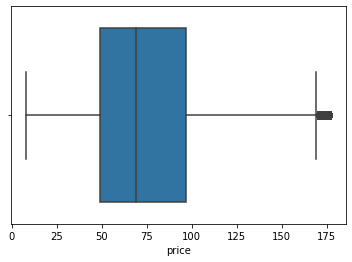

In [382]:
sns.boxplot(x=calendar_out['price'])

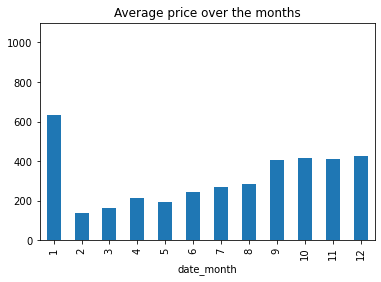

In [218]:
plt.ylim(0, 1100)
calendar.groupby(['date_month'])['price'].mean().plot(kind='bar', title = 'Average price over the months');